# 14.32 final paper - step 4, instrumental variables

## Setup

In [1]:
import pandas as pd
import numpy as np
import microdf as mdf
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mdf.set_plot_style()

## Load data

In [3]:
county = pd.read_csv('data/county.csv')
county_date = pd.read_csv('data/county_date.csv')
cps = pd.read_csv('data/cps.csv.gz')

/home/mghenis/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
for i in ['school_closure_date', 'date']:
    county_date[i] = pd.to_datetime(county_date[i])
county.school_closure_date = pd.to_datetime(county.school_closure_date)

## First stage

In [5]:
first_closure_date = county_date.school_closure_date.min()

In [6]:
county_date['school_closure_date_num'] = (
    county_date.school_closure_date - first_closure_date).dt.days
county_date = sm.add_constant(county_date)

In [7]:
county_date_valid = county_date.dropna()

In [8]:
def get_t(cases, var):
    regs = sm.WLS(cases.school_closure_date_num,
                  cases[[var, 'const']],
                  weights=cases.POPESTIMATE2019).fit().summary()
    return float(regs.tables[1][1].data[3])

In [9]:
def get_ts(cases):
    return pd.Series([get_t(cases, 'cases'), get_t(cases, 'deaths'),
                      get_t(cases, 'cases_pc'), get_t(cases, 'deaths_pc'),
                      get_t(cases, 'log_cases_pc'),
                      get_t(cases, 'log_deaths_pc')],
                     index=['cases', 'deaths', 'cases_pc', 'deaths_pc',
                            'log_cases_pc', 'log_deaths_pc'])

In [10]:
fs_df = county_date_valid[county_date_valid.date.between(
    '2020-03-01', '2020-03-31')].groupby('date').apply(get_ts)

In [11]:
fs_df

,cases,deaths,cases_pc,deaths_pc,log_cases_pc,log_deaths_pc
date,,,,,,
2020-03-01,-2.411,-2.246,-1.574,-2.246,-2.623,-2.246
2020-03-02,-2.497,-2.327,-1.952,-2.327,-2.978,-2.327
2020-03-03,-3.172,-2.426,-2.567,-2.426,-3.914,-2.426
2020-03-04,-1.519,-2.564,-2.465,-2.511,-2.655,-2.457
2020-03-05,-1.435,-2.704,-2.672,-2.663,-2.490,-2.614
2020-03-06,-1.013,-3.026,-2.211,-2.973,-2.232,-2.866
2020-03-07,-0.925,-3.120,-1.518,-3.094,-2.213,-2.991
2020-03-08,-0.945,-3.032,-1.462,-3.004,-2.023,-2.899
2020-03-09,-1.110,-3.021,-1.655,-3.001,-2.118,-2.816


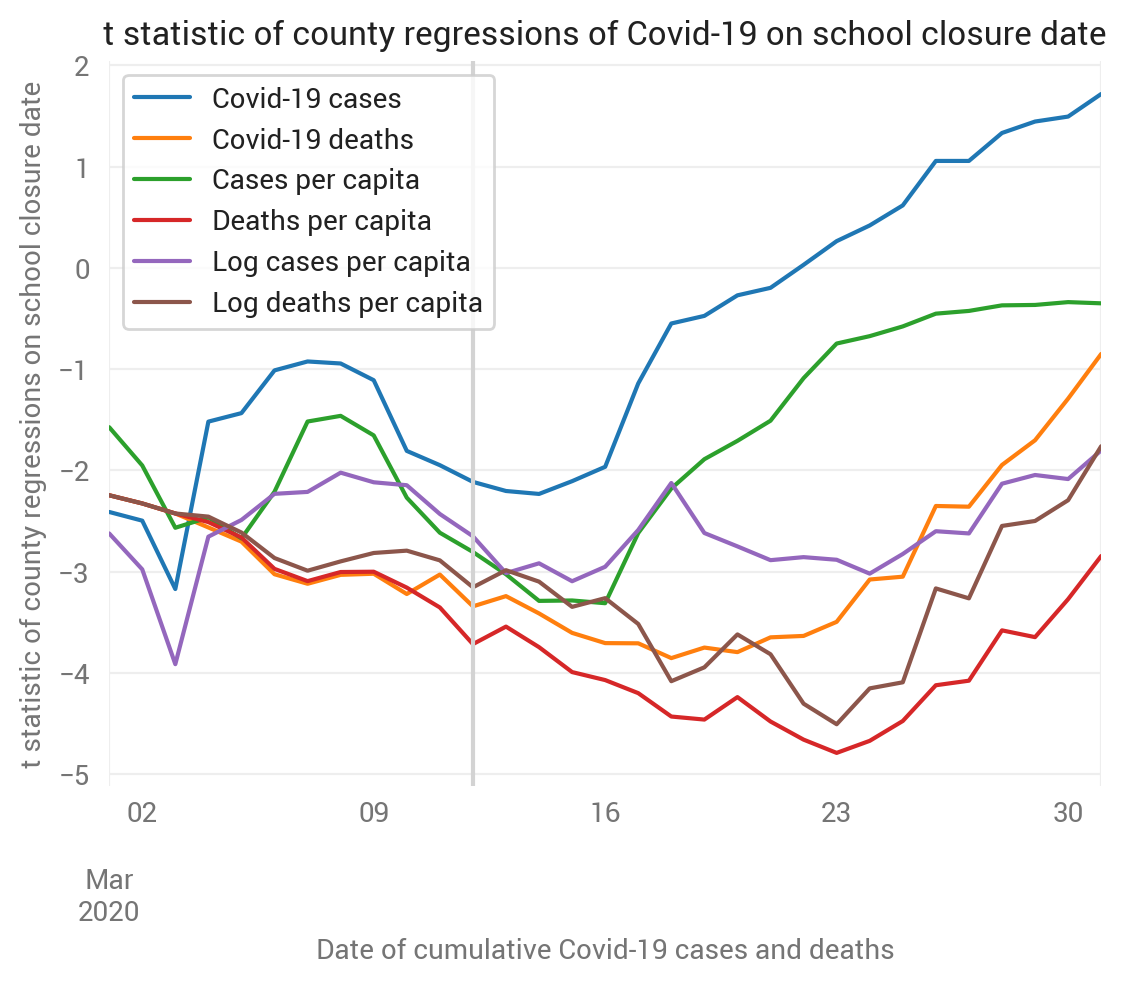

In [12]:
ax = fs_df.plot()
ax.axvline('2020-03-12', c='lightgray')
plt.xlabel('Date of cumulative Covid-19 cases and deaths')
plt.ylabel('t statistic of county regressions on school closure date')
plt.legend(['Covid-19 cases', 'Covid-19 deaths',
            'Cases per capita', 'Deaths per capita',
            'Log cases per capita', 'Log deaths per capita'])
plt.savefig('charts/tstats.png')
plt.title('t statistic of county regressions of Covid-19 on school closure date')
plt.show()

In [13]:
fs_df.loc[:first_closure_date].iloc[:-1]

,cases,deaths,cases_pc,deaths_pc,log_cases_pc,log_deaths_pc
date,,,,,,
2020-03-01,-2.411,-2.246,-1.574,-2.246,-2.623,-2.246
2020-03-02,-2.497,-2.327,-1.952,-2.327,-2.978,-2.327
2020-03-03,-3.172,-2.426,-2.567,-2.426,-3.914,-2.426
2020-03-04,-1.519,-2.564,-2.465,-2.511,-2.655,-2.457
2020-03-05,-1.435,-2.704,-2.672,-2.663,-2.490,-2.614
2020-03-06,-1.013,-3.026,-2.211,-2.973,-2.232,-2.866
2020-03-07,-0.925,-3.120,-1.518,-3.094,-2.213,-2.991
2020-03-08,-0.945,-3.032,-1.462,-3.004,-2.023,-2.899
2020-03-09,-1.110,-3.021,-1.655,-3.001,-2.118,-2.816


Use Covid-19 deaths per capita on the date before the first school closure.

In [14]:
COVID_DT = '2020-03-11'

In [15]:
county_date_covid = county_date_valid[county_date_valid.date == COVID_DT]

In [16]:
sm.WLS(county_date_covid.school_closure_date_num,
       county_date_covid[['deaths_pc', 'const']],
       county_date_covid.POPESTIMATE2019).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               WLS Regression Results                              
===================================================================================
Dep. Variable:     school_closure_date_num   R-squared:                       0.075
Model:                                 WLS   Adj. R-squared:                  0.068
Method:                      Least Squares   F-statistic:                     11.25
Date:                     Sun, 31 May 2020   Prob (F-statistic):            0.00103
Time:                             18:57:10   Log-Likelihood:                -322.35
No. Observations:                      141   AIC:                             648.7
Df Residuals:                          139   BIC:                             654.6
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
deaths_pc     -0.3491      0.104     -3.354      0.001      -0.555      -0.143
const          4.3101      0.165     26.124      0.000       3.984       4.636
==============================================================================
Omnibus:                       54.730   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              275.721
Skew:                           1.266   Prob(JB):                     1.34e-60
Kurtosis:                       9.366   Cond. No.                         1.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

That is, each Covid-19 death per million population as of 2020-03-11 is
associated with schools being closed 0.35 days earlier.

Look at full set of Covid features to consider multiple instruments.

In [17]:
sm.WLS(county_date_covid.school_closure_date_num,
       county_date_covid[['cases', 'cases_pc', 'log_cases_pc',
                          'deaths', 'deaths_pc', 'log_deaths_pc', 'const']],
       county_date_covid.POPESTIMATE2019).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               WLS Regression Results                              
===================================================================================
Dep. Variable:     school_closure_date_num   R-squared:                       0.234
Model:                                 WLS   Adj. R-squared:                  0.200
Method:                      Least Squares   F-statistic:                     6.840
Date:                     Sun, 31 May 2020   Prob (F-statistic):           2.39e-06
Time:                             18:57:10   Log-Likelihood:                -309.00
No. Observations:                      141   AIC:                             632.0
Df Residuals:                          134   BIC:                             652.7
Df Model:                                6                                         
Covariance Type:                 nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
cases             0.0464      0.022      2.103      0.037       0.003       0.090
cases_pc         -0.0204      0.024     -0.857      0.393      -0.068       0.027
log_cases_pc     -0.4775      0.280     -1.704      0.091      -1.032       0.077
deaths            1.1235      0.670      1.676      0.096      -0.202       2.449
deaths_pc        -4.7484      1.721     -2.760      0.007      -8.151      -1.345
log_deaths_pc     6.0478      2.287      2.645      0.009       1.525      10.571
const             4.5789      0.367     12.474      0.000       3.853       5.305
==============================================================================
Omnibus:                       27.141   Durbin-Watson:                   1.583
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.368
Skew:                           0.517   Prob(JB):                     1.98e-26
Kurtosis:                       7.368   Cond. No.                         752.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

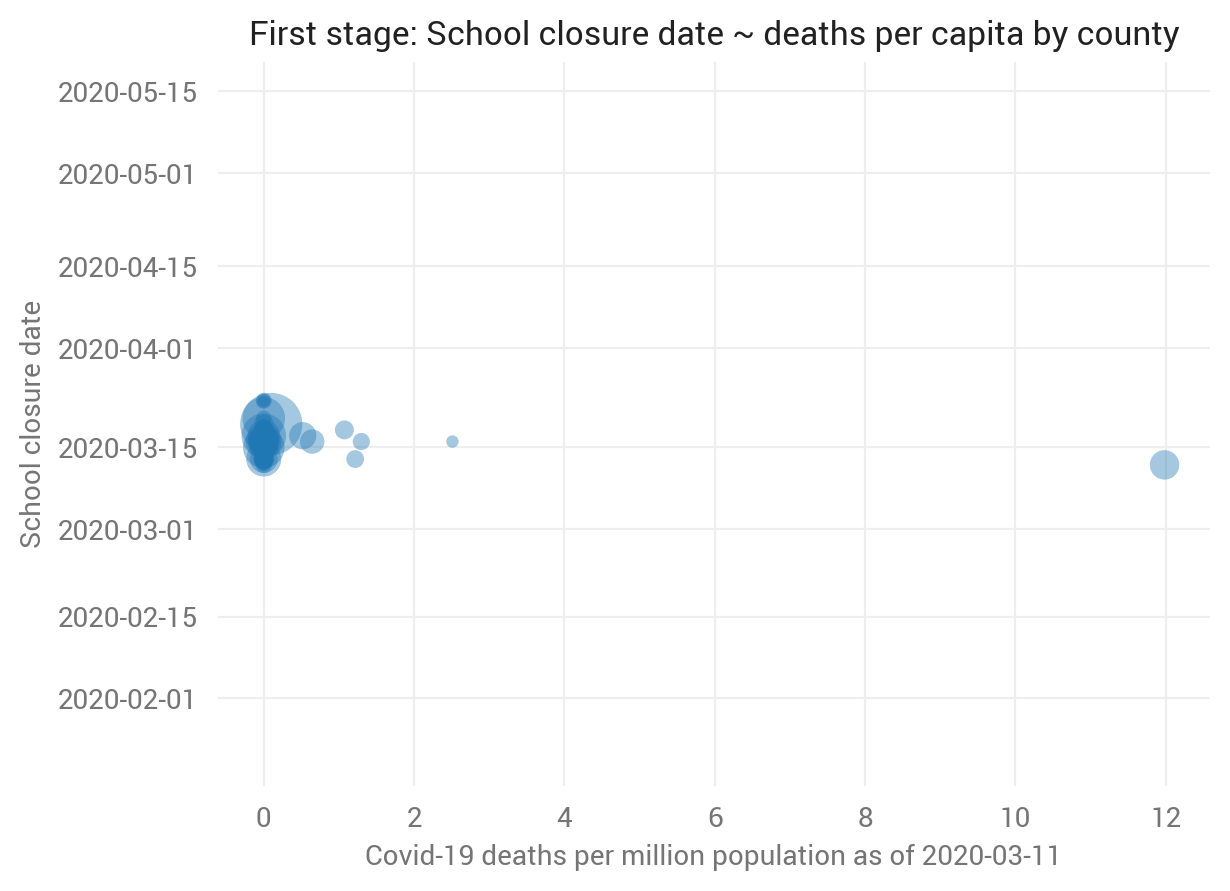

In [18]:
county_date_covid.plot.scatter(x='deaths_pc', y='school_closure_date',
                               s=county_date_covid.POPESTIMATE2019 / 2e4,
                               alpha=0.4, edgecolors='none')
plt.xlabel('Covid-19 deaths per million population as of 2020-03-11')
plt.ylabel('School closure date')
plt.savefig('charts/fs_deathspc.png')
plt.title('First stage: School closure date ~ deaths per capita by county')
plt.show()

Apply fixed effects by de-meaning, to be able to stay with `statsmodels` rather than
`linearmodels` which doesn't work with `stargazer`.

See https://stackoverflow.com/a/24196288/1840471:

```
   ybar = y.mean()
    y = y -  y.groupby(data[absorb]).transform('mean') + ybar

    Xbar = X.mean()
    X = X - X.groupby(data[absorb]).transform('mean') + Xbar

    reg = sm.OLS(y,X)
    # Account for df loss from FE transform
    reg.df_resid -= (data[absorb].nunique() - 1)
```

## Instrument

Instrument for school closure using employment rate of mothers as of January 2020.

In [19]:
cps.columns

Index(['YEAR', 'MONTH', 'COUNTY', 'w', 'age', 'age2', 'female', 'married',
       'hours', 'POPESTIMATE2019', 'school_closure_date', 'cps_start_date',
       'cps_end_date', 'unemp', 'emp', 'lf', 'emp_of_lf', 'has_k5', 'days_sc',
       'post', 'post_has_k5', 'lwe', 'days_since_2000', 'apr2020',
       'apr2020_has_k5', 'days_sc_has_k5', 'apr2020_has_k5_female',
       'apr2020_female', 'has_k5_female', 'days_sc_has_k5_female',
       'days_sc_female'],
      dtype='object')

In [20]:
cps['emp_mother'] = cps.has_k5_female & cps.emp

In [21]:
cps_jan2020_mothers = cps[(cps.YEAR == 2020) & (cps.MONTH == 1) &
                          cps.has_k5_female]

In [22]:
county_mother_emp_jan2020 = cps_jan2020_mothers.groupby('COUNTY').apply(
    lambda x: mdf.weighted_mean(x, 'emp_mother', 'w')
)

In [23]:
county_mother_emp_jan2020

COUNTY
0        0.724160
1003     0.825123
1081     0.628143
1097     0.571985
4013     0.684050
           ...   
55059    1.000000
55073    1.000000
55101    0.730632
55105    0.576900
55139    1.000000
Length: 280, dtype: float64

In [24]:
county_mother_emp_jan2020 = pd.DataFrame(county_mother_emp_jan2020)
county_mother_emp_jan2020.columns = ['mother_emp_jan2020']

In [25]:
cps.columns

Index(['YEAR', 'MONTH', 'COUNTY', 'w', 'age', 'age2', 'female', 'married',
       'hours', 'POPESTIMATE2019', 'school_closure_date', 'cps_start_date',
       'cps_end_date', 'unemp', 'emp', 'lf', 'emp_of_lf', 'has_k5', 'days_sc',
       'post', 'post_has_k5', 'lwe', 'days_since_2000', 'apr2020',
       'apr2020_has_k5', 'days_sc_has_k5', 'apr2020_has_k5_female',
       'apr2020_female', 'has_k5_female', 'days_sc_has_k5_female',
       'days_sc_female', 'emp_mother'],
      dtype='object')

In [26]:
county_mother_emp = county.merge(county_mother_emp_jan2020,
                                 left_on='fips', right_on='COUNTY')

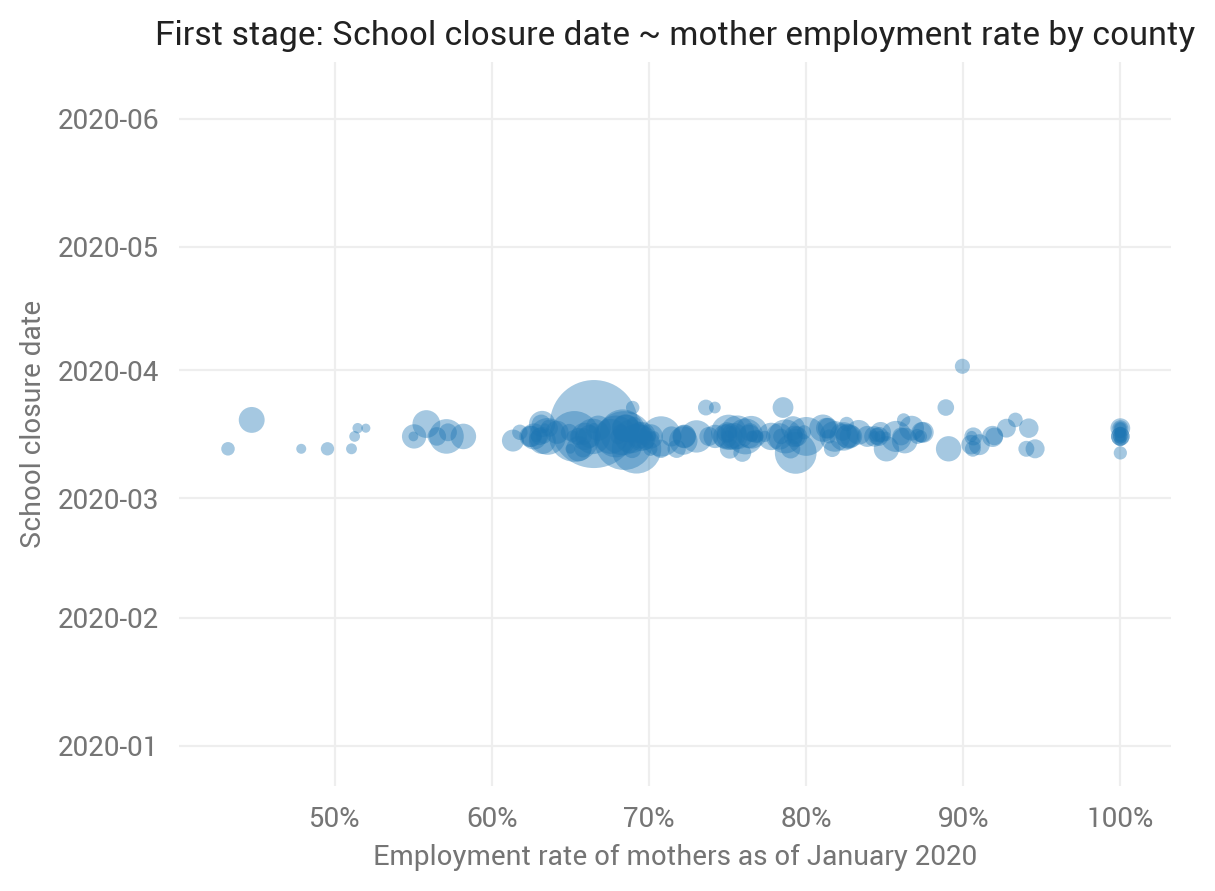

In [27]:
ax = county_mother_emp.plot.scatter(x='mother_emp_jan2020',
                                    y='school_closure_date',
                                    s=county_mother_emp.POPESTIMATE2019 / 1e4,
                                    alpha=0.4, edgecolors='none')
plt.xlabel('Employment rate of mothers as of January 2020')
plt.ylabel('School closure date')
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.savefig('charts/fs_motheremp.png')
plt.title('First stage: School closure date ~ mother employment rate by ' +
          'county')
plt.show()

In [28]:
county_mother_emp['school_closure_date_num'] = (
    county_mother_emp.school_closure_date - first_closure_date).dt.days
county_mother_emp = sm.add_constant(county_mother_emp)

In [29]:
county_mother_emp.describe()

,const,fips,POPESTIMATE2019,mother_emp_jan2020,school_closure_date_num
count,279.0,279.000000,2.790000e+02,279.000000,171.000000
mean,1.0,27695.878136,5.329247e+05,0.752731,4.339181
std,0.0,14960.127481,8.039116e+05,0.164546,2.371804
min,1.0,1003.000000,1.028550e+05,0.000000,0.000000
25%,1.0,13070.000000,1.699160e+05,0.660551,4.000000
50%,1.0,26125.000000,2.809790e+05,0.750653,4.000000
75%,1.0,39123.000000,5.690370e+05,0.861092,5.000000
max,1.0,55139.000000,1.003911e+07,1.000000,21.000000


In [30]:
sm.OLS(county_mother_emp.school_closure_date_num,
       county_mother_emp[['mother_emp_jan2020', 'const']], missing='drop').fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     school_closure_date_num   R-squared:                       0.004
Model:                                 OLS   Adj. R-squared:                 -0.002
Method:                      Least Squares   F-statistic:                    0.7248
Date:                     Sun, 31 May 2020   Prob (F-statistic):              0.396
Time:                             18:57:12   Log-Likelihood:                -389.46
No. Observations:                      171   AIC:                             782.9
Df Residuals:                          169   BIC:                             789.2
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
mother_emp_jan2020     1.2065      1.417      0.851      0.396      -1.591       4.004
const                  3.4247      1.089      3.144      0.002       1.274       5.575
==============================================================================
Omnibus:                      119.172   Durbin-Watson:                   1.652
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1491.287
Skew:                           2.354   Prob(JB):                         0.00
Kurtosis:                      16.680   Cond. No.                         12.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
county_mother_emp.dropna().drop('const', axis=1).corr()

,fips,POPESTIMATE2019,mother_emp_jan2020,school_closure_date_num
fips,1.000000,-0.189496,0.106512,-0.180350
POPESTIMATE2019,-0.189496,1.000000,-0.144430,-0.005261
mother_emp_jan2020,0.106512,-0.144430,1.000000,0.065351
school_closure_date_num,-0.180350,-0.005261,0.065351,1.000000
